In [28]:
import warnings 
warnings.filterwarnings(action='ignore')

import numpy as np
import pandas as pd
import tensorflow as tf
import re
import os
import nltk
import datetime

from gensim.models.fasttext import FastText
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize

from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from tqdm import tqdm_notebook

In [29]:
# 데이터 불러오기

raw_train = pd.read_csv('/content/drive/MyDrive/[데이콘] 소설 작가 분류 AI 경진대회/data/train.csv')
raw_test = pd.read_csv('/content/drive/MyDrive/[데이콘] 소설 작가 분류 AI 경진대회/data/test_x.csv')
sample_submission = pd.read_csv('/content/drive/MyDrive/[데이콘] 소설 작가 분류 AI 경진대회/data/sample_submission.csv')

In [30]:
train = raw_train.copy()
test = raw_test.copy()

In [31]:
def alpha_num(text):
    return re.sub(r'[^A-Za-z0-9 ]', '', text)


def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stopwords:
            final_text.append(i.strip())
    return " ".join(final_text)

stopwords = ['the', 'a', 'to', 'of', 'in', 'an', 'as', 'at', 'as', 'with', 'above', 'on', 'or', 'over', 'by', 'to', 'and']
# stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", 
#              "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", 
#              "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", 
#              "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", 
#              "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", 
#              "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", 
#              "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", 
#              "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", 
#              "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", 
#              "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", 
#              "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves"]

In [32]:
train['text'] = train['text'].str.lower().apply(alpha_num).apply(remove_stopwords)
test['text'] = test['text'].str.lower().apply(alpha_num).apply(remove_stopwords)

In [33]:
X_train = train['text'].values
X_test = test['text'].values
y = train['author'].values.reshape(-1, 1)
print(X_train.shape, X_test.shape, y.shape)

(54879,) (19617,) (54879, 1)


In [34]:
count_by_author = []

for idx in range(5):
    df = train[train['author']==idx]['text'].values
    temp_tokenizer = Tokenizer()

    temp_tokenizer.fit_on_texts(df)
    temp_dict = temp_tokenizer.word_counts
    temp_dict = sorted(temp_dict.items(), key=lambda x : x[1], reverse=True)
    print('작가 {}의 유니크한 단어수 {}' .format(idx, len(temp_dict)))
    count_by_author.append(dict(temp_dict))

작가 0의 유니크한 단어수 20602
작가 1의 유니크한 단어수 15410
작가 2의 유니크한 단어수 21014
작가 3의 유니크한 단어수 19186
작가 4의 유니크한 단어수 17799


In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

<Figure size 1080x1440 with 0 Axes>

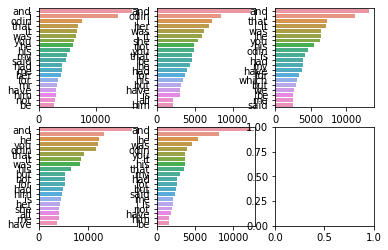

In [10]:

plt.figure(figsize=(15, 20))

fig, axes = plt.subplots(2, 3)

sns.barplot(y=list(count_by_author[0].keys())[:20], x=list(count_by_author[0].values())[:20], ax=axes[0, 0])
sns.barplot(y=list(count_by_author[1].keys())[:20], x=list(count_by_author[1].values())[:20], ax=axes[0, 1])
sns.barplot(y=list(count_by_author[2].keys())[:20], x=list(count_by_author[2].values())[:20], ax=axes[0, 2])
sns.barplot(y=list(count_by_author[3].keys())[:20], x=list(count_by_author[3].values())[:20], ax=axes[1, 0])
sns.barplot(y=list(count_by_author[4].keys())[:20], x=list(count_by_author[4].values())[:20], ax=axes[1, 1])

(array([    0.,  2000.,  4000.,  6000.,  8000., 10000., 12000., 14000.,
        16000., 18000.]), <a list of 10 Text major ticklabel objects>)

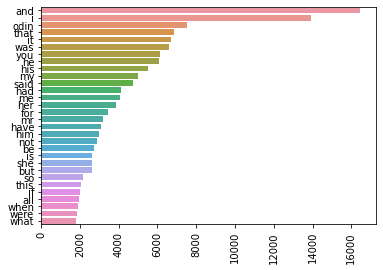

In [11]:
sns.barplot(y=list(count_by_author[0].keys())[:30], x=list(count_by_author[0].values())[:30])
plt.xticks(rotation=90)

In [ ]:
ordering_by_author = []



sorted(count_by_author[0].items(), key=lambda x : x[1], reverse=True)

In [36]:
max_length = 500
padding_type='post'
vocab_size= 30000

In [37]:
tokenizer = Tokenizer(oov_token='oov', num_words = vocab_size)
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(X_train)
test_sequences = tokenizer.texts_to_sequences(X_test)

x_train = pad_sequences(train_sequences, padding=padding_type, maxlen=max_length)
x_test = pad_sequences(test_sequences, padding=padding_type, maxlen=max_length)
print(x_train.shape, x_test.shape)

(54879, 500) (19617, 500)


## 1. FastText 사용하기

In [38]:
!pip install fasttext

In [39]:
import fasttext
import fasttext.util

In [40]:
print(f"== LOAD fasttext START at {datetime.datetime.now()}")
ft = fasttext.load_model('/content/drive/MyDrive/FastText/cc.en.300.bin')
print(f"== LOAD fasttext   END at {datetime.datetime.now()}")

== LOAD fasttext START at 2020-11-30 09:03:48.905186
== LOAD fasttext   END at 2020-11-30 09:05:58.339003


In [41]:
embedding_dim = 300
embedding_matrix = np.zeros( (len(word_index)+1, embedding_dim) )

In [42]:
# 임베딩테이블 만들기
for word, idx in word_index.items():
    embedding_vector = ft.get_word_vector(word)
    if embedding_vector is not None :
        embedding_matrix[idx] = embedding_vector

In [43]:
# 임베딩 테이블
embedding_matrix

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.21967494e-02,  1.47352798e-03, -3.66373621e-02, ...,
         3.82993668e-02, -6.97156740e-03,  3.46689485e-02],
       [ 3.03138583e-03, -1.43692493e-01, -1.69851527e-01, ...,
         5.63688934e-01, -4.45606351e-01, -2.60577857e-01],
       ...,
       [-1.14901196e-02,  1.77695379e-02, -7.17559550e-03, ...,
         1.88565888e-02, -2.11709607e-02, -1.53971398e-02],
       [-1.79175157e-02,  1.67236254e-02, -7.29322061e-03, ...,
         1.72605272e-04,  1.51997712e-03, -2.69044321e-02],
       [-4.95688394e-02,  2.36806385e-02,  1.32462056e-02, ...,
        -1.53529341e-03,  6.91159070e-03,  3.62609886e-02]])

In [44]:
target_col = 'author'
n_class = 5
seed = 42

In [45]:
import tensorflow.keras.backend as K
# Mish 활성화 함수
def mish(x):
    return x * K.tanh(K.softplus(x))

In [ ]:
vocab_size

In [61]:
def get_model() :

    from tensorflow.keras import Sequential
    from tensorflow.keras.layers import Dense, Embedding, LSTM, GlobalMaxPooling1D, Conv1D, Dropout, Bidirectional, Flatten, MaxPool1D, GlobalAveragePooling1D, AveragePooling1D
    import tensorflow as tf

    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim, weights=[embedding_matrix[0:30000]], input_length=max_length))
    model.add(Dropout(0.2))
    model.add(Conv1D(filters=50, kernel_size=3, padding='same', activation=mish, strides=1))
    model.add(GlobalAveragePooling1D())
    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(50, mish))
    model.add(Dropout(0.2))
    model.add(Dense(n_class, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.005))

    return model


## 2. Hold Out

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train_holdout, X_test_holdout, y_train_holdout, y_test_holdout = train_test_split(x_train, y, test_size=0.2, random_state=123)

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2, restore_best_weights=True)

In [ ]:
model = get_model()
history = model.fit(X_train_holdout, y_train_holdout, 
                    epochs           = 20,
                    callbacks        = [es],
                    batch_size       = 32,
                    validation_data = (X_test_holdout, y_test_holdout))

Epoch 1/20
1372/1372 [==============================] - 90s 65ms/step - loss: 0.9608 - val_loss: 0.6963
Epoch 2/20
 806/1372 [================>.............] - ETA: 36s - loss: 0.5986

KeyboardInterrupt: ignored

## 3. K-Fold

In [49]:

# 5-Fold 시행
from sklearn.model_selection import StratifiedKFold
cv = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)

In [ ]:
validation_pred = np.zeros((y.shape[0], n_class))
test_pred = np.zeros((test.shape[0], n_class))

i = 0
for train_idx, val_idx in tqdm_notebook(cv.split(x_train, y)):
    print("{}-Fold" .format(i+1))
    X_train = x_train[train_idx]
    y_train = y[train_idx]

    X_validation = x_train[val_idx]
    y_validation = y[val_idx]

    CNN = get_model()

    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2, restore_best_weights=True)

    CNN.fit(X_train, y_train,
             epochs           = 20,
             callbacks        = [es],
             batch_size       = 32,
             validation_data  = (X_validation, y_validation))
    
    validation_pred[val_idx, :] = CNN.predict(X_validation)
    test_pred += (CNN.predict(x_test) / 5)
    print('')

    i += 1

1-Fold
Epoch 1/20
1372/1372 [==============================] - 154s 112ms/step - loss: 1.0234 - val_loss: 0.7215
Epoch 2/20
1372/1372 [==============================] - 154s 112ms/step - loss: 0.5968 - val_loss: 0.6550
Epoch 3/20
1372/1372 [==============================] - 156s 114ms/step - loss: 0.4554 - val_loss: 0.7008
Epoch 4/20
1372/1372 [==============================] - 155s 113ms/step - loss: 0.3784 - val_loss: 0.7488
Epoch 00004: early stopping

2-Fold
Epoch 1/20
1372/1372 [==============================] - 160s 116ms/step - loss: 0.9880 - val_loss: 0.7073
Epoch 2/20
1372/1372 [==============================] - 157s 114ms/step - loss: 0.5811 - val_loss: 0.6650
Epoch 3/20
1372/1372 [==============================] - 158s 115ms/step - loss: 0.4497 - val_loss: 0.6997
Epoch 4/20
1372/1372 [==============================] - 159s 116ms/step - loss: 0.3745 - val_loss: 0.7460
Epoch 00004: early stopping

3-Fold
Epoch 1/20
1372/1372 [==============================] - 156s 114ms/step -

In [ ]:
CNN.summary()

NameError: ignored

In [53]:
from sklearn.metrics import log_loss, recall_score, confusion_matrix

In [54]:
y_pred = np.argmax(validation_pred, axis=1)
y_real = y.reshape((1, -1))[0]

In [55]:
confusion_matrix(y_pred, y_real)

array([[ 9907,   705,   838,   744,   906],
       [  526,  4997,   307,   354,   149],
       [ 1014,   710,  8542,  1087,   877],
       [ 1058,   625,  1211, 12562,   573],
       [  730,   185,   656,   316,  5300]])

In [56]:
# log_loss

log_loss(pd.get_dummies(y_real), validation_pred)

0.6685693883318483

In [58]:
# 결과 저장
sample_submission[['0','1','2','3','4']] = test_pred
sample_submission.to_csv('/content/drive/MyDrive/[데이콘] 소설 작가 분류 AI 경진대회/02_나의코드/01_딥러닝/Test예측결과/submission_12.csv', index = False, encoding = 'utf-8')